In [447]:
%load_ext autoreload
%autoreload 2

import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm
import multiprocessing
multiprocessing.set_start_method("fork")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#! need to change sigma in two places!
model = """
data {
  int<lower=0> N;
  vector[N] y;
}
parameters {
  real mu;
}
model {
  real sigma=1;
  real mu0=0;
  real sigma0=10;
  mu ~ normal(mu0, sigma0);
  y ~ normal(mu, sigma);
}
generated quantities {
  vector[N] log_lik;
  real sigma=1;
  for (n in 1:N) 
    log_lik[n] = normal_lpdf(y[n] | mu, sigma);
}
"""

# compile the model
sm = pystan.StanModel(model_code=model)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2214e789e3dd09a92dda4ee012dc92d7 NOW.


In [9]:
np.random.seed(1)

N = 100
sigma = 1
mu = 3
mu0 = 0
sigma0 = 10
y = np.random.normal(loc=mu, scale=sigma, size=N)

# put our data in a dictionary
data = {'N': N, 'y': y}

In [10]:
# train the model and generate samples
fit = sm.sampling(n_jobs=1, data=data, iter=1000, chains=4, warmup=500, thin=1, seed=1)

In [11]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_2214e789e3dd09a92dda4ee012dc92d7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu            3.06  3.5e-3    0.1   2.86   2.99   3.06   3.12   3.24    777    1.0
log_lik[1]   -2.15  5.5e-3   0.15  -2.48  -2.25  -2.15  -2.05  -1.87    772    1.0
log_lik[2]   -1.15  2.4e-3   0.07  -1.28  -1.19  -1.14   -1.1  -1.03    771    1.0
log_lik[3]   -1.09  2.1e-3   0.06  -1.22  -1.13  -1.09  -1.05  -0.99    769    1.0
log_lik[4]   -1.56  4.0e-3   0.11  -1.78  -1.63  -1.56  -1.49  -1.35    774    1.0
log_lik[5]   -1.25  2.9e-3   0.08  -1.43   -1.3  -1.25  -1.19  -1.11    769    1.0
log_lik[6]   -3.71  8.3e-3   0.23  -4.15  -3.86   -3.7  -3.55  -3.25    777    1.0
log_lik[7]   -2.35  5.9e-3   0.16   -2.7  -2.46  -2.34  -2.23  -2.05    773    1.0
log_lik[8]   -1.26  2.9e-3

In [12]:
# gather into dataframe
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
lp = fit["lp__"]
mu_pos = fit["mu"]

loglik_val = fit["log_lik"].sum(axis=1)

In [13]:
np.mean(mu_pos), np.std(mu_pos)

(3.0570127266836185, 0.09751885023554471)

In [2]:
def log_posterior(mu, sigma, mu0, sigma0, y):
    N = len(y)
    sd = (1 / sigma0**2 + N / sigma**2)**(-1)
    mean = sd * (mu0 / sigma0**2 + np.sum(y) / sigma**2)
    log_pos = - 1 / (2*sd**2) * (mu - mean)**2
    return log_pos


def loglik(mu, sigma, y):
    # N = len(y)
    term1 = - 0.5 * np.log(2 * np.pi * sigma**2)
    term2 = - 1/(2 * sigma**2) * (y - mu)**2
    return term1 + term2

def posterior_den(mu, y):
    true_pos_var = (1 / sigma0**2 + len(y) / sigma**2)**(-1)
    true_pos_mean = true_pos_var * (mu0 / sigma0**2 + np.sum(y) / sigma**2)
    return norm.pdf(mu, loc=true_pos_mean, scale=np.sqrt(true_pos_var))


In [28]:
print("loglik:", loglik_val[0], loglik(mu_pos[0], sigma, y).sum() + norm.logpdf(mu_pos[0], loc=mu0, scale=sigma0))
print("posterior:", lp[0], loglik(mu_pos[0], sigma, y).sum() + norm.logpdf(mu_pos[0], loc=mu0, scale=sigma0))

loglik: -131.3299095142406 -134.60050624877482
posterior: -41.78771439510288 -134.60050624877482


In [30]:
for i in range(5):
    print(lp[i] - (loglik(mu_pos[i], sigma, y).sum() + norm.logpdf(mu_pos[i], loc=mu0, scale=sigma0)))

92.81279185367194
92.81279185367191
92.81279185367192
92.81279185367194
92.81279185367194


-131.3299095142406 -131.32990951424057


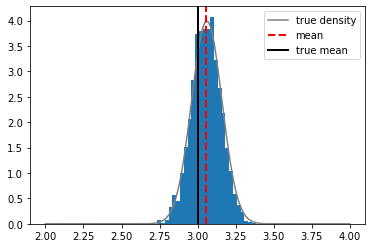

In [19]:
# log_posterior(mu_pos, sigma, mu0=0, sigma0=1, y=y)
print(loglik_val[0], loglik(mu_pos[0], sigma, y).sum())


# plot posterior samples and mean
x_plot = np.linspace(2, 4, 500)
plt.hist(mu_pos, 30, density=True)
plt.plot(x_plot, posterior_den(x_plot, y), color="grey", label="true density")
plt.axvline(np.mean(mu_pos), color='r', lw=2, linestyle='--',label='mean')
plt.axvline(mu, color='k', lw=2, linestyle='-',label='true mean')
plt.legend()
plt.show()

In [11]:
# add new data and update posterior samples
n_new = 100
y_new = np.zeros(n_new)
mu_hat = np.zeros(n_new)
mu_hat[0] = mu_pos.mean()
for i in range(1, n_new):
    y_new_val = np.random.normal(loc=mu, scale=sigma, size=1)
    weights = np.exp(loglik(mu_pos, sigma, y_new_val))
    mu_hat[i] = (mu_pos * weights / weights.sum()).sum()
    y_new[i] = y_new_val

    if (i+1) % 10 == 0:
        print("MSE:", np.mean((mu_hat[i] - mu)**2))


# y_full = np.vstack((y.reshape(-1, 1), y_new.reshape(-1, 1)))
# true_pos_sd = (1 / sigma0**2 + len(y_full) / sigma**2)**(-1)
# true_pos_mean = true_pos_sd * (mu0 / sigma0**2 + np.sum(y_full) / sigma**2)
# x_plot = np.linspace(0, 6, 500)
# # true_pos_den = norm.pdf(x_plot, loc=true_pos_mean, scale=true_pos_sd)
# true_pos_sample = np.random.normal(loc=true_pos_mean, scale=true_pos_sd, size=1000)





MSE: 0.011016430753745119
MSE: 0.018103337606946115
MSE: 0.002712196104636783
MSE: 0.009504536150839966
MSE: 0.0066592437570996395
MSE: 0.010841588634587005
MSE: 0.007558379527502618
MSE: 0.009473482697629184
MSE: 0.02818352919415477
MSE: 0.018060642659209633


In [ ]:
plt.scatter(range(n_new), mu_hat)
plt.axhline(mu, color="k", lw=2, linestyle="-",label="true mean")
plt.legend()
plt.show()

plt.hist(mu_hat, 30, density=True, label="sampled posterior", alpha=0.5)
plt.hist(true_pos_sample, 30, density=True, color="grey", label="true density", alpha=0.5)
plt.show()

# plt.hist(mu_hat, 30, density=True)
# plt.scatter(x_plot, true_pos_den, color="grey", label="true density")
# plt.show()

# Tensorflow Probability

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [4]:
tf.random.set_seed(1)

N = 100
mu = np.array([3.])
sigma = np.array([1.])
mu0 = np.array([0.])
sigma0 = np.array([10.])
gen_model = tfd.Normal(loc=mu, scale=sigma)
y = gen_model.sample(N)

In [5]:
y.shape

TensorShape([100, 1])

In [61]:
def posterior_den(mu, y):
    '''True posterior density
    '''
    true_pos_var = (1 / sigma0**2 + len(y) / sigma**2)**(-1)
    true_pos_mean = true_pos_var * (mu0 / sigma0**2 + np.sum(y) / sigma**2)
    return norm.pdf(mu, loc=true_pos_mean, scale=np.sqrt(true_pos_var))

In [7]:
# define log_prob for the unnormalized posterior
def log_prob(mu, y, sigma, mu0, sigma0):
    '''
    Args:
        mu: 1 x nsamples
        y: ndata
    Output:
        log_prob: 1 x nsamples
    '''
    rv_data = tfd.Normal(mu, sigma)
    rv_prior = tfd.Normal(mu0, sigma0)
    return tf.reduce_sum(rv_data.log_prob(y), axis=0) + rv_prior.log_prob(mu)

# currying data and hyperparams
def unnormalized_posterior(mu):
    return log_prob(mu, y, sigma, mu0, sigma0)

In [8]:
# create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_posterior,
    step_size=np.float64(.1),
    num_leapfrog_steps=2)

In [9]:
# wrap sample_chain in tf.function
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=hmc_kernel,
        trace_fn=lambda current_state, kernel_results: kernel_results)

In [10]:
initial_state = np.zeros(1)
samples, kernel_results = run_chain(initial_state)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

Acceptance rate: 0.918


In [11]:
# adaptive step size during burnin
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        hmc_kernel,
        num_adaptation_steps=int(.4 * num_burnin_steps),
        target_accept_prob=np.float64(.65))

    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=adaptive_kernel,
        trace_fn=lambda cs, kr: kr)

In [12]:
samples, kernel_results = run_chain(
    initial_state=np.zeros(1))
print("Acceptance rate:", kernel_results.inner_results.is_accepted.numpy().mean())

Acceptance rate: 0.655


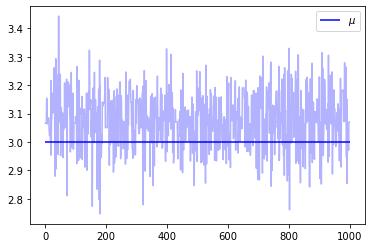

/opt/anaconda3/envs/fast-mcmc/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


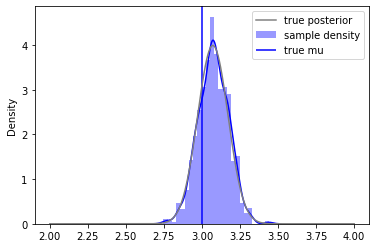

In [13]:
# trace plots
plt.plot(samples, c="b", alpha=.3)
plt.hlines(mu, 0, 1000, zorder=4, color="b", label="$\mu$")
plt.legend()
plt.show()

# Histogram of samples
sns.distplot(samples, color="b", label="sample density")
ymax = plt.ylim()[1]
plt.vlines(mu, 0, ymax, color="b", label="true mu")
plt.ylim(0, ymax)
x_plot = np.linspace(2, 4, 500)
plt.plot(x_plot, posterior_den(x_plot, y), color="grey", label="true posterior")
plt.legend()
plt.show()

## Importance sampling

In [14]:
# add new data and update estimate
n_new = 1
y_all = y
mu_hat = np.zeros(n_new + 1)
mu_hat[0] = np.mean(samples)
samples = tf.reshape(samples, (1, -1))
for i in range(n_new):
    y_all_old = y_all
    y_new = gen_model.sample(100)
    y_all = tf.concat([y_all, y_new], axis=0)
    
    # compute weights
    log_prob_diff = log_prob(samples, y_all, sigma, mu0, sigma0) - log_prob(samples, y_all_old, sigma, mu0, sigma0)
    weights = np.exp(log_prob_diff)
    
    # form SN-IS estimate
    mu_hat[i+1] = np.sum(samples * weights / np.sum(weights))

    if (i+1) % 10 == 0:
        print("MSE:", np.mean((mu_hat[i] - mu)**2))


In [15]:
print("old and new mu_hat", mu_hat)

old and new mu_hat [3.07527537 3.04759147]


In [124]:
# define log_prob for the unnormalized posterior
def log_prob(mu, y, sigma, mu0, sigma0):
    '''
    Args:
        mu: 1 x nsamples
        y: ndata
    Output:
        log_prob: 1 x nsamples
    '''
    rv_data = tfd.Normal(mu, sigma)
    rv_prior = tfd.Normal(mu0, sigma0)
    return tf.reduce_sum(rv_data.log_prob(y), axis=0) + rv_prior.log_prob(mu)

# currying data and hyperparams
def unnormalized_posterior(mu):
    return log_prob(mu, y, sigma, mu0, sigma0)

In [16]:
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_posterior,
    step_size=np.float64(.1),
    num_leapfrog_steps=2)

@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        hmc_kernel,
        num_adaptation_steps=int(.4 * num_burnin_steps),
        target_accept_prob=np.float64(.65))

    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=adaptive_kernel,
        trace_fn=lambda cs, kr: kr)

samples_new, kernel_results_new = run_chain(
    initial_state=np.zeros(1))
print("Acceptance rate:", kernel_results_new.inner_results.is_accepted.numpy().mean())

Acceptance rate: 0.631


In [17]:
print("HMC estimate:", np.mean(samples_new), "SN-IS estimate:", mu_hat[-1])

HMC estimate: 3.0479126901127995 SN-IS estimate: 3.0475914681986374


# SMC

In [5]:
samples = tf.reshape(samples, (-1, 1))
y = tf.reshape(y, (1, -1))
y_all = tf.reshape(y_all, (1, -1))

In [64]:
def posterior_den(mu, y):
    '''True posterior density
    '''
    true_pos_var = (1 / sigma0**2 + y.shape[1] / sigma**2)**(-1)
    true_pos_mean = true_pos_var * (mu0 / sigma0**2 + np.sum(y) / sigma**2)
    return norm.pdf(mu, loc=true_pos_mean, scale=np.sqrt(true_pos_var))

In [79]:
def loglik(mu):
    # N = len(y)
    term1 = - 0.5 * np.log(2 * np.pi * sigma**2)
    term2 = - 1/(2 * sigma**2) * (y_all - mu)**2
    return term1 + tf.reduce_sum(term2, axis=1, keepdims=True)

def smc(seed):
    return tfp.experimental.mcmc.sample_sequential_monte_carlo(
        prior_log_prob_fn=lambda x: -(x - mu0)**2 / (2 * sigma0**2),
        likelihood_log_prob_fn=loglik,
        current_state=samples,
        seed=seed)[1]

In [80]:
smc_res = smc(seed=(12, 34))

[0.009999] [3.07142396] 1
[0.00499975] [3.04493744] 1


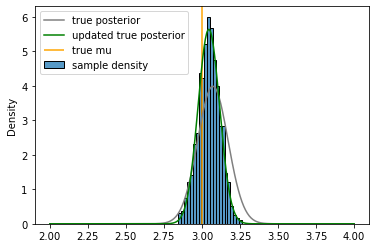

In [104]:
# Histogram of samples
smc_res_plot = tf.reshape(smc_res, -1)
sns.histplot(smc_res_plot, stat="density", label="sample density")
ymax = plt.ylim()[1]
plt.vlines(mu, 0, ymax, color="orange", label="true mu")
plt.ylim(0, ymax)
x_plot = np.linspace(2, 4, 500)
plt.plot(x_plot, posterior_den(x_plot, y), color="grey", label="true posterior")
plt.plot(x_plot, posterior_den(x_plot, y_all), color="green", label="updated true posterior")
plt.legend()
plt.show()

## SMC Manual

In [51]:
tf.random.set_seed(1)

N = 1000
mu = np.array([3.])
sigma = np.array([1.])
mu0 = np.array([0.])
sigma0 = np.array([10.])
gen_model = tfd.Normal(loc=mu, scale=sigma)
t_total = 5
y = tf.transpose(gen_model.sample(50))

In [52]:
def resample(log_probs, x):
    ind = tfd.Categorical(logits=tf.transpose(log_probs)).sample(log_probs.shape[0])
    return tf.gather_nd(x, ind)

class Proposal:
    def __init__(self):
        self.dist = tfd.Normal(np.array([0.]), np.array([1.]))
    def log_prob(self, mu_new, mu_curr):
        return self.dist.log_prob(mu_new) # nsample x dim
    def sample(self, size, mu_curr):
        return self.dist.sample(size)
    
# define log_prob for the unnormalized posterior
def log_prob(mu, y, sigma, mu0, sigma0):
    '''
    Args:
        mu: 1 x nsamples
        y: ndata
    Output:
        log_prob: 1 x nsamples
    '''
    rv_data = tfd.Normal(mu, sigma)
    rv_prior = tfd.Normal(mu0, sigma0)
    return tf.reduce_sum(rv_data.log_prob(y), axis=1, keepdims=True) + rv_prior.log_prob(mu)

In [53]:
mu_pos_list = [0] * t_total
mu_pos_resampled_list = [0] * t_total
log_weights_list = [0] * t_total

In [54]:
# initialize 
proposal = Proposal()
# sample from proposal
mu_pos = proposal.sample(N, None)
# compute weights
log_weights = log_prob(mu_pos, y, sigma, mu0, sigma0) - proposal.log_prob(mu_pos, None)
# resample 
mu_pos_resampled = resample(log_weights, mu_pos)
# store res
mu_pos_list[0] = mu_pos
mu_pos_resampled_list[0] = mu_pos_resampled
log_weights_list[0] = log_weights

In [55]:
for t in range(1, t_total):
    mu_pos = proposal.sample(N, None)
    # compute weights
    log_alpha = log_prob(mu_pos, y, sigma, mu0, sigma0) 
    log_alpha -= log_prob(mu_pos_resampled_list[t-1], y, sigma, mu0, sigma0)
    log_alpha -= proposal.log_prob(mu_pos, None)
    # resample
    mu_pos_resampled = resample(log_alpha, mu_pos)
    # store res
    mu_pos_list[t] = mu_pos
    mu_pos_resampled_list[t] = mu_pos_resampled
    log_weights_list[t] = log_weights

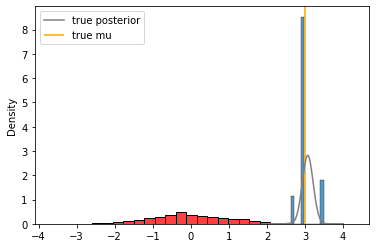

In [65]:
sns.histplot(tf.reshape(mu_pos, -1), stat="density", color="r")
sns.histplot(tf.reshape(mu_pos_resampled, -1), stat="density")
ymax = plt.ylim()[1]
plt.vlines(mu, 0, ymax, color="orange", label="true mu")
plt.ylim(0, ymax)
x_plot = np.linspace(2, 4, 500)
plt.plot(x_plot, posterior_den(x_plot, y), color="grey", label="true posterior")
plt.legend()
plt.show()

# D&C SMC

In [589]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import sys
sys.path.append(".")
from src.dc_smc import dc_smc 
from src.model import Model

In [590]:
class Proposal:
    def __init__(self):
        self.dist = tfd.Normal(np.zeros(1), np.ones(1))
    def log_prob(self, mu_new, mu_curr):
        return self.dist.log_prob(mu_new) # nsample x dim
    def sample(self, size, mu_curr):
        return self.dist.sample(size)[:, :, 0]

In [591]:
tf.random.set_seed(1)

N = 50 # num params samples
nobs = 100 # num observations

sigma, tau, gamma = np.array([1.]), np.array([1.]), np.array([1.])
mu0, sigma0 = np.array([0.]), np.array([1.])

x5 = np.array([3.])
x4, x3 = tfd.Normal(loc=x5, scale=gamma).sample(2)
x1, x2 = tfd.Normal(loc=x4, scale=tau).sample(2)
x_true = tf.reshape(tf.concat([x1, x2, x3, x4, x5], axis=0), (1, -1))


In [592]:
# simulate data
y1 = tfd.Normal(loc=x_true[:, 0], scale=sigma).sample((nobs, 1))
y2 = tfd.Normal(loc=x_true[:, 1], scale=sigma).sample((nobs, 1))
y3 = tfd.Normal(loc=x_true[:, 2], scale=sigma).sample((nobs, 1))
obs = tf.transpose(tf.concat([y1, y2, y3], axis=1)[:, :, 0])

In [593]:
# proposal density
proposal = Proposal()

In [594]:
def log_gamma_leaf(samples, obs):
    '''
        samples: nsamples x 1
        obs: nobs x 1
    '''
    loglik = tfd.Normal(loc=samples, scale=sigma).log_prob(obs)
    logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(samples)
    return tf.reduce_sum(loglik, axis=1, keepdims=True) + logprior

In [595]:
# unnormalized densities

# leaves
log_gamma1 = lambda x: log_gamma_leaf(x[:, :1], obs[:1, :])
log_gamma2 = lambda x: log_gamma_leaf(x[:, 1:2], obs[1:2, :])
log_gamma3 = lambda x: log_gamma_leaf(x[:, 2:3], obs[2:, :])

# gamma4
def log_gamma4(x):
    loglik_1 = tfd.Normal(loc=x[:, :1], scale=sigma).log_prob(obs[:1, :])
    loglik_2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[1:2, :])
    loglik = tf.reduce_sum(loglik_1 + loglik_2, axis=1, keepdims=True)
    
    logp_x1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, :1])
    logp_x2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])
    logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 3:4])
    return loglik + logp_x1 + logp_x2 + logprior

# gamma5
def log_gamma5(x):
    loglik_1 = tfd.Normal(loc=x[:, :1], scale=sigma).log_prob(obs[:1, :])
    loglik_2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[1:2, :])
    loglik_3 = tfd.Normal(loc=x[:, 2:3], scale=sigma).log_prob(obs[2:3, :])
    loglik = tf.reduce_sum(loglik_1 + loglik_2 + loglik_3, axis=1, keepdims=True)
    
    logp_x1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, :1])
    logp_x2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])
    logp_x4 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 3:4])
    logp_x3 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 2:3])
    
    logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 4:5])
    
    return loglik + logp_x1 + logp_x2 + logp_x4 + logp_x3 + logprior


In [596]:
model = Model(log_gamma5, proposal, 4)
model.build_left(log_gamma4, proposal, 3)
model.build_right(log_gamma3, proposal, 2)
model.left.build_left(log_gamma1, proposal, 1)
model.left.build_right(log_gamma2, proposal, 0)

In [597]:
tf.random.set_seed(1)
samples_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1)).sample((N, 5))[:, :, 0]
log_w_init = np.ones(samples_init.shape)

In [598]:
samples_res, log_w = dc_smc(samples_init, weights_init, model)

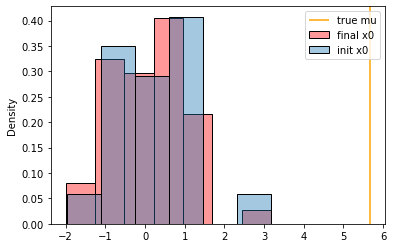

In [599]:
ind = 0

sns.histplot(tf.reshape(samples_res[:, ind], -1), stat="density", color="r", alpha=0.4, label=f"final x{ind}")
sns.histplot(tf.reshape(samples[:, ind], -1), stat="density", alpha=0.4, label=f"init x{ind}")
ymax = plt.ylim()[1]
plt.vlines(x_true[0, ind], 0, ymax, color="orange", label="true mu")
plt.ylim(0, ymax)
x_plot = np.linspace(2, 4, 500)
# plt.plot(x_plot, posterior_den(x_plot, y), color="grey", label="true posterior")
plt.legend()
plt.show()